# Final Project: Deep Learning Plant Seedlings Classification with CNN 

## Problem to Solve: Plant Seedlings Classification
This project analyzes and applies Convolutional Neural Networks which is one of deep learning algorithms to solve a Kaggle challenge. 
The challenge is about classifying different seeds during planting. The ability to do so effectively can mean better crop yields and better stewardship of the environment.

https://www.kaggle.com/c/plant-seedlings-classification/overview

## Data Source
The data was downloaded from the internet.

https://www.kaggle.com/c/plant-seedlings-classification/data

Data includes: 

A. Train data

B. Test data 
## Deep Learning Methods Used
CNN: This is a powerful deep learning method to classify plant seedlings based on input.


# Table of Contents:
1. Import depencies or libraries that need to be used in this project
2. EDA step. Read the data from train directory and Clean up data or reformat data for the purposes of the project
3. EDA step. Display plots for the input data
4. Apply CNN and display plots
5. Tunning and use different parameters to train the model
6. Tunning and use different parameters to train the model
7. Apply CNN on the test data
8. Takeaways

### 1. Import depencies or libraries that need to be used in this project


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)

# Path to test and train data
train_dir = os.path.join(current_dir, 'input/train/')
test_dir = os.path.join(current_dir, 'input/test/')
print("train_dir: ", train_dir)
print("test_dir: ", test_dir)
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.png')]
test_df = pd.DataFrame({'filename': test_image_paths})

DEBUG_VERBOSE = False

Current working directory: /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week6
train_dir:  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week6/input/train/
test_dir:  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week6/input/test/


### 2. EDA step. Read the data from train directory and check data to make sure they are qualified.

In [2]:
image_paths = []
image_labels = []
image_shapes = []
categories = os.listdir(train_dir)

for category in categories:
    category_path = os.path.join(train_dir, category)
    for img_path in glob(os.path.join(category_path, '*.png')):
        image_paths.append(img_path)
        image_labels.append(category)
        image_shapes.append(Image.open(img_path).size)

# process input images and create data frame
df = pd.DataFrame({
    'file': image_paths,
    'species': image_labels,
    'width': [shape[0] for shape in image_shapes],
    'height': [shape[1] for shape in image_shapes]
})

# show some info
print(df.head())
print(df.describe())
print(df.info())

# check null values
print(df.isnull().sum())


                                                file      species  width  \
0  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/D...  Black-grass    196   
1  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/D...  Black-grass    388   
2  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/D...  Black-grass    886   
3  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/D...  Black-grass    117   
4  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/D...  Black-grass    471   

   height  
0     196  
1     388  
2     886  
3     117  
4     471  
             width       height
count  4750.000000  4750.000000
mean    371.465895   370.730105
std     323.275012   318.649607
min      49.000000    49.000000
25%     140.000000   140.000000
50%     266.500000   266.500000
75%     507.750000   507.000000
max    3991.000000  3457.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0 

Discussions: After processing input data, we can know more about the distributions of widths and heights in the train folder. We also know if we've read and processed input data and our environments and paths have been set up correctly.

### 3. EDA step. Display plots for the input data

A. Label Distribution Plot

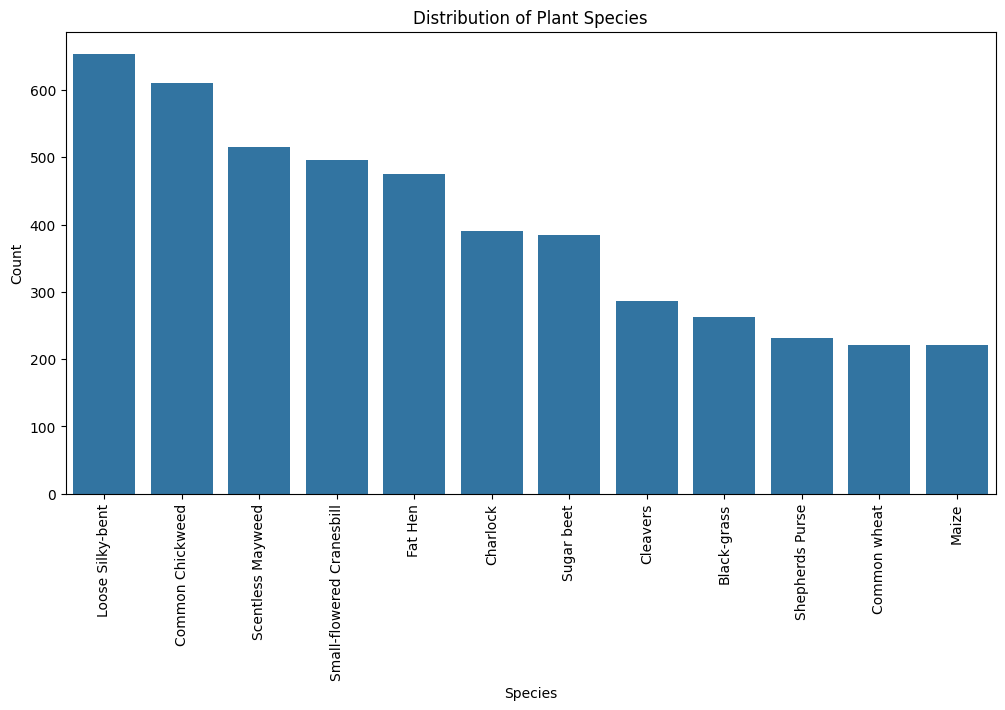

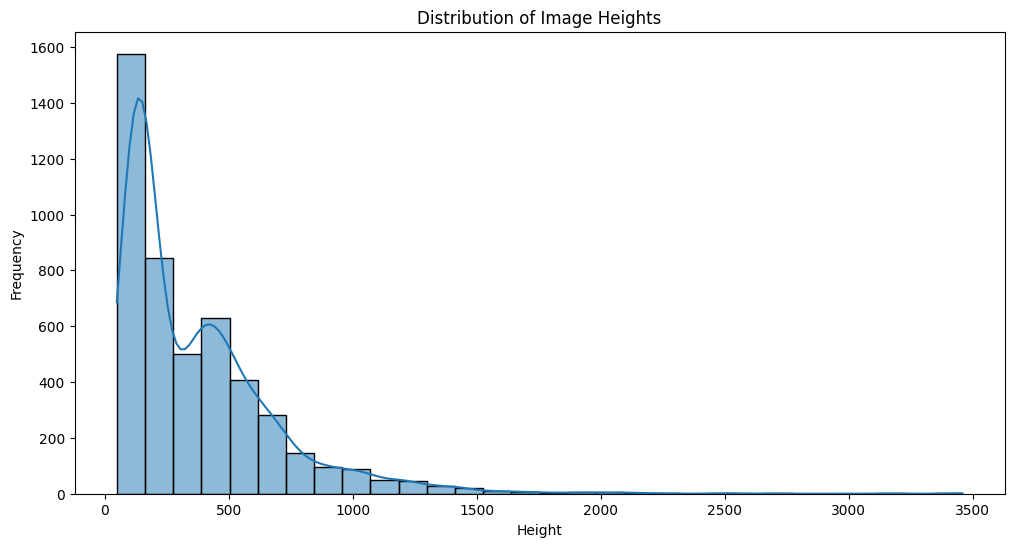

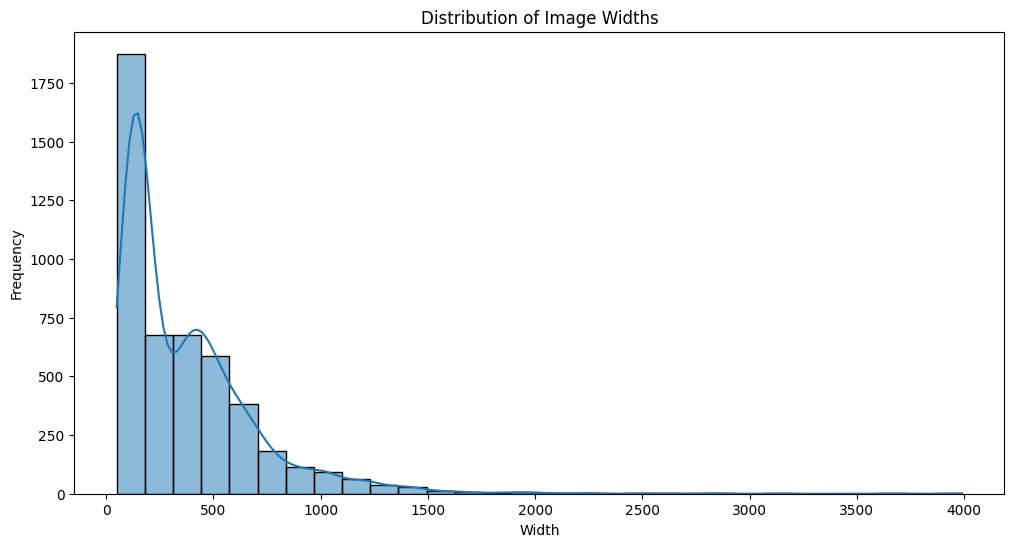

In [3]:
# plot distribution of species
plt.figure(figsize=(12, 6))
sns.countplot(x='species', data=df, order=df['species'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Plant Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

# plot distribution of heights
plt.figure(figsize=(12, 6))
sns.histplot(df['height'], kde=True, bins=30)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

# plot distribution of widths
plt.figure(figsize=(12, 6))
sns.histplot(df['width'], kde=True, bins=30)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()


Discussions: The data input for each categories seems to be pretty even. This means the data is good and there is no biased among species. Most of widths and heights are around a certain range which mean the image sizes of each category have similar formats.

B. Show Images from training data input

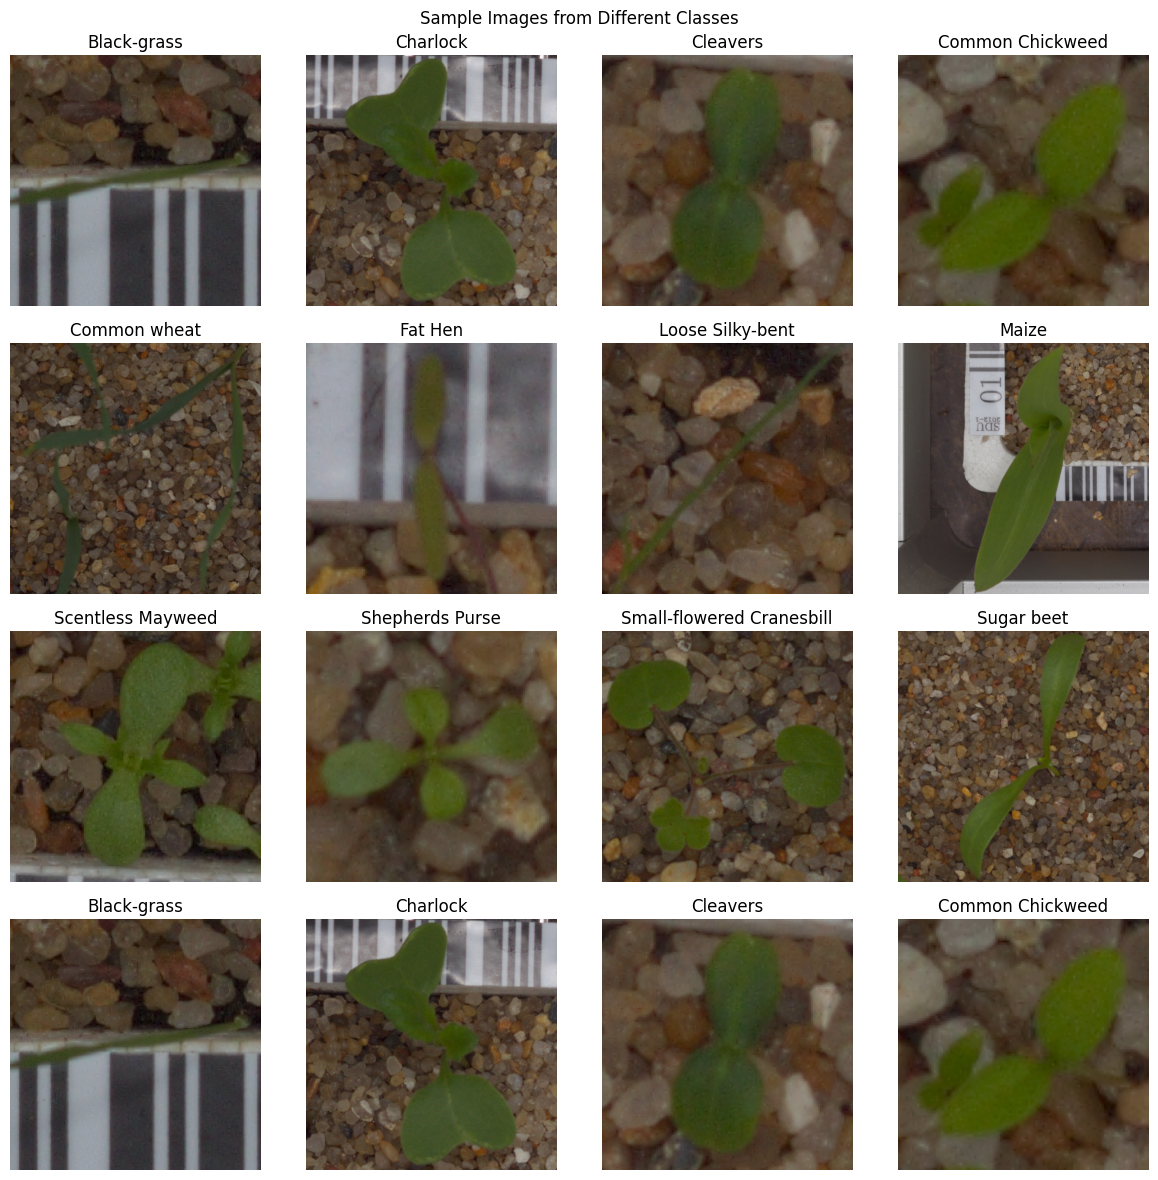

In [4]:
# show some sample images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample Images from Different Classes')
species = df['species'].unique()
for i, ax in enumerate(axes.flat):
    sample_image_path = df[df['species'] == species[i % len(species)]]['file'].values[0]
    img = Image.open(sample_image_path)
    ax.imshow(img)
    ax.set_title(species[i % len(species)])
    ax.axis('off')
plt.tight_layout()
plt.show()
    

Discussions: These are images that got pulled from train data.They show different types of cancers vs non-cancers. There is a variety of data which mean the input is  

### 4. Apply CNN and display plots

#### A. Apply CNN with differemtn params

##### Plans: Apply the method with params such as:

1/ batch_size = 2 means each iteration will have 2 items

2/ epoch = 50 means how many times we will iterate through the input data

3/ ImageDataGenerator with less params

4/ learning rate = defult Adam library with 0.0001

5/ fewer layers to model architecture when the model is built with Sequential 


In [8]:
# Parameters
batch_size = 2
num_of_epochs = 50
learning_rate = 0.0001

# ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load model
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96), 
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='categorical', 
    subset='validation'
)

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Print steps per epoch and validation steps
print(f'steps_per_epoch : {steps_per_epoch}')
print(f'validation_steps : {validation_steps}')

# Define the CNN model
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(12, activation='softmax')
])

# Compile with Adam optimizer and specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save this model to use for test data
model_save_path = 'current_model.keras'

# Stop if nothing gets better
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, mode='min')

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=num_of_epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
current_model = load_model(model_save_path)

# Print validation
validation_loss, validation_accuracy = current_model.evaluate(validation_generator, steps=validation_steps)
print(f'Validation Accuracy: {validation_accuracy}')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
steps_per_epoch : 1901
validation_steps : 473
Epoch 1/50
1901/1901 ━━━━━━━━━━━━━━━━━━━━ 167s 87ms/step - accuracy: 0.0848 - loss: 3.6240 - val_accuracy: 0.1501 - val_loss: 3.0321
Epoch 2/50
1901/1901 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.0000e+00 - loss: 3.5096 - val_accuracy: 0.0000e+00 - val_loss: 3.0550
Epoch 3/50


2024-06-23 17:13:51.439083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:13:51.448334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1901/1901 ━━━━━━━━━━━━━━━━━━━━ 165s 87ms/step - accuracy: 0.1544 - loss: 3.0956 - val_accuracy: 0.1448 - val_loss: 3.0413
Epoch 4/50
1901/1901 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.0000e+00 - loss: 3.0891 - val_accuracy: 0.0000e+00 - val_loss: 2.6233
Epoch 5/50


2024-06-23 17:16:36.736003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:16:36.743773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1901/1901 ━━━━━━━━━━━━━━━━━━━━ 170s 89ms/step - accuracy: 0.1397 - loss: 3.0522 - val_accuracy: 0.1956 - val_loss: 2.9534
Epoch 6/50
1901/1901 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.5000 - loss: 2.6171 - val_accuracy: 0.0000e+00 - val_loss: 2.9576
Epoch 7/50


2024-06-23 17:19:27.166318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:19:27.194902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1901/1901 ━━━━━━━━━━━━━━━━━━━━ 167s 88ms/step - accuracy: 0.1378 - loss: 2.9915 - val_accuracy: 0.2019 - val_loss: 2.8280
Epoch 8/50
1901/1901 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.5000 - loss: 2.9800 - val_accuracy: 0.0000e+00 - val_loss: 3.2253
Epoch 9/50


2024-06-23 17:22:14.487879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:22:14.499389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1901/1901 ━━━━━━━━━━━━━━━━━━━━ 176s 92ms/step - accuracy: 0.1632 - loss: 2.9098 - val_accuracy: 0.2093 - val_loss: 2.6679
473/473 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.1712 - loss: 3.0241
Validation Accuracy: 0.16067653894424438


#### B. Display Plots

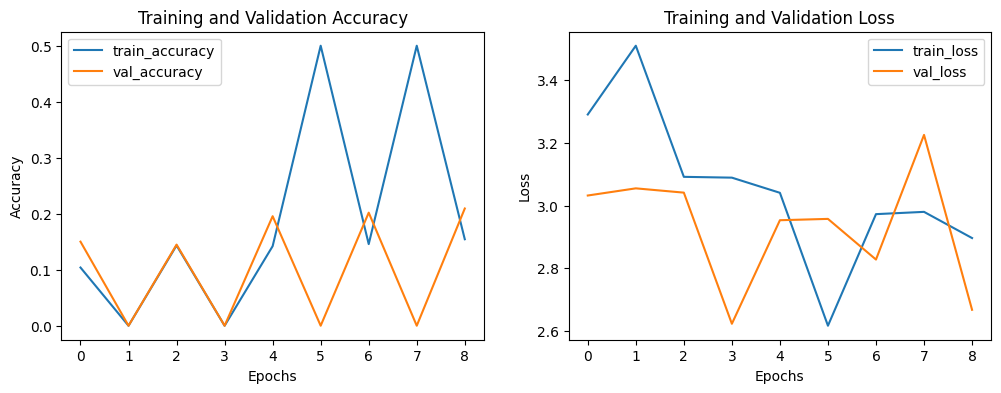

In [9]:
# plot training results for visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

Discussions: As epoch increments, we can see train loss and validation loss decrementing which show the models is being improved.

The train loss and accuracy are reaching their peaks which means they cant be improved much futher.

Validation loss and accuracy are stable but they are up and down which is normal.

For example: The values start at accuracy: 0.7747 - loss: 0.4849 - val_accuracy: 0.8438 - val_loss: 0.3479

At the end, the values are accuracy: 0.5000 - loss: 2.9800 - val_accuracy: 0.0000e+00 - val_loss: 3.2253

### 5. Tunning and use different parameters to train the model

Plans: Apply the method with params such as:

1/ batch_size = 32 means each iteration will have 32 items

2/ epoch = 25 means how many times the data will go back and forth in the training process.

3/ ImageDataGenerator with more params

4/ learning rate = 0.001

5/ Added more layers to model architecture when the model is built with Sequential 

#### A. Apply CNN with differemtn params

In [5]:
# Parameters
batch_size = 32
epochs = 25
learning_rate = 0.001

# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load model
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size
print(f"steps_per_epoch : {steps_per_epoch}")
print(f"validation_steps : {validation_steps}")

# Build the CNN model
model = Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile with a different optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Stop if nothing gets better
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Print validation
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_accuracy}")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
steps_per_epoch : 118
validation_steps : 29
Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.1432 - loss: 2.4269 - val_accuracy: 0.3017 - val_loss: 2.0333
Epoch 2/25
  1/118 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.1875 - loss: 1.9990

2024-06-23 05:37:32.955459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1875 - loss: 1.9990 - val_accuracy: 0.1053 - val_loss: 2.3091
Epoch 3/25


2024-06-23 05:37:33.266022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.2779 - loss: 2.0138 - val_accuracy: 0.3621 - val_loss: 1.7589
Epoch 4/25
  1/118 ━━━━━━━━━━━━━━━━━━━━ 36s 311ms/step - accuracy: 0.2812 - loss: 2.0950

2024-06-23 05:40:20.040500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 2.0950 - val_accuracy: 0.3684 - val_loss: 1.5963
Epoch 5/25


2024-06-23 05:40:20.301429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3718 - loss: 1.7866 - val_accuracy: 0.4472 - val_loss: 1.6035
Epoch 6/25
  1/118 ━━━━━━━━━━━━━━━━━━━━ 33s 286ms/step - accuracy: 0.4062 - loss: 1.6924

2024-06-23 05:43:11.037100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 1.6924 - val_accuracy: 0.3684 - val_loss: 1.8306
Epoch 7/25


2024-06-23 05:43:11.380908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.4253 - loss: 1.6337 - val_accuracy: 0.4741 - val_loss: 1.4599
Epoch 8/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.2188 - loss: 1.7530 - val_accuracy: 0.5789 - val_loss: 1.1436
Epoch 9/25


2024-06-23 05:46:06.890246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 05:46:06.995425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4618 - loss: 1.5292 - val_accuracy: 0.5032 - val_loss: 1.3920
Epoch 10/25
  1/118 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - accuracy: 0.3750 - loss: 1.5777

2024-06-23 05:49:09.586286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3750 - loss: 1.5777 - val_accuracy: 0.5263 - val_loss: 1.2224
Epoch 11/25


2024-06-23 05:49:09.864721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5143 - loss: 1.3595 - val_accuracy: 0.5571 - val_loss: 1.2573
Epoch 12/25
  1/118 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - accuracy: 0.7188 - loss: 1.1356

2024-06-23 05:52:09.433721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 1.1356 - val_accuracy: 0.3684 - val_loss: 1.4408
Epoch 13/25


2024-06-23 05:52:10.173596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5285 - loss: 1.3448 - val_accuracy: 0.5905 - val_loss: 1.2138
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4950 - loss: 1.4230
Validation Accuracy: 0.4931362271308899


#### B. Display Plots

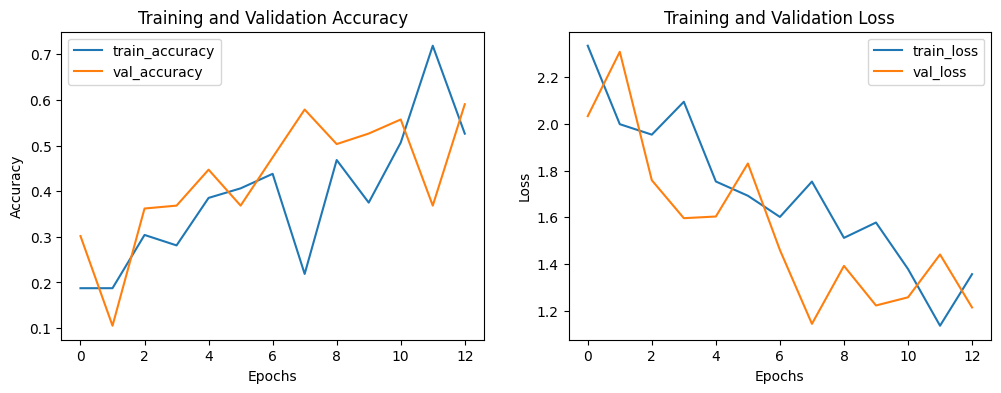

In [6]:
# plot training results for visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

Discussions: As epoch increments, we can see train loss and validation loss decrementing which show the models is being improved. The train loss and accuracy are reaching their peaks which means they cant be improved much futher. Validation loss and accuracy are stable but they are up and down which is normal. For example: accuracy: 0.1432 - loss: 2.4269 - val_accuracy: 0.3017 - val_loss: 2.0333. At the end, the values are accuracy: 0.5285 - loss: 1.3448 - val_accuracy: 0.5905 - val_loss: 1.2138

### 6. Tunning and use different parameters to train the model

Plans: Apply the method with params such as:

1/ batch_size = 32 means each iteration will have 32 items

2/ epoch = 100 means how many times the data will go back and forth in the training process.

3/ ImageDataGenerator with more params

4/ learning rate = 0.0001

5/ Added more layers to model architecture when the model is built with Sequential 


#### A. Apply CNN on train data 

In [6]:
# Parameters
batch_size = 32
num_of_epochs = 100
learning_rate = 0.0001

# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load model
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size
print(f"steps_per_epoch : {steps_per_epoch}")
print(f"validation_steps : {validation_steps}")

# Build the CNN model
model = Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile with a different optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save this model to use for test data
model_save_path = 'best_model.keras'

# Stop if nothing gets better
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, mode='min')

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=num_of_epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
best_model = load_model(model_save_path)

# Print validation
validation_loss, validation_accuracy = best_model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_accuracy}")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
steps_per_epoch : 118
validation_steps : 29
Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.1181 - loss: 2.4584 - val_accuracy: 0.2629 - val_loss: 2.1443
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.1875 - loss: 2.1543 - val_accuracy: 0.2632 - val_loss: 2.2304
Epoch 3/100


2024-06-23 18:38:25.832485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-23 18:38:25.889340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:38:36.365865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-23 18:38:37.716052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer fille

118/118 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.2589 - loss: 2.1649 - val_accuracy: 0.3157 - val_loss: 1.9320
Epoch 4/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.4062 - loss: 1.9186

2024-06-23 18:41:47.402356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:41:47.458392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4062 - loss: 1.9186 - val_accuracy: 0.4737 - val_loss: 1.6501
Epoch 5/100


2024-06-23 18:41:59.572711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-23 18:42:00.865038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


118/118 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.2688 - loss: 2.0386 - val_accuracy: 0.3534 - val_loss: 1.8191
Epoch 6/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 49s 422ms/step - accuracy: 0.2812 - loss: 1.8031

2024-06-23 18:45:35.363246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 1.8031 - val_accuracy: 0.2632 - val_loss: 1.9113
Epoch 7/100


2024-06-23 18:45:35.646589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.3115 - loss: 1.9421 - val_accuracy: 0.4181 - val_loss: 1.7312
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 2.0211 - val_accuracy: 0.5263 - val_loss: 1.8055
Epoch 9/100


2024-06-23 18:49:03.266516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:49:03.445834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.3623 - loss: 1.8344 - val_accuracy: 0.4526 - val_loss: 1.6159
Epoch 10/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.4062 - loss: 1.6172

2024-06-23 18:52:17.959399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:52:18.012988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4062 - loss: 1.6172 - val_accuracy: 0.6842 - val_loss: 1.3296
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3936 - loss: 1.7169 - val_accuracy: 0.5054 - val_loss: 1.4899
Epoch 12/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 40s 344ms/step - accuracy: 0.3438 - loss: 2.0231

2024-06-23 18:55:39.617831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3438 - loss: 2.0231 - val_accuracy: 0.5789 - val_loss: 1.3369
Epoch 13/100


2024-06-23 18:55:40.040767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.4379 - loss: 1.6180 - val_accuracy: 0.5593 - val_loss: 1.3435
Epoch 14/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.4118 - val_accuracy: 0.5263 - val_loss: 1.4924
Epoch 15/100


2024-06-23 18:59:17.590469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:59:17.771947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.4859 - loss: 1.4839 - val_accuracy: 0.5744 - val_loss: 1.2707
Epoch 16/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.4375 - loss: 1.3815 - val_accuracy: 0.6316 - val_loss: 1.4434
Epoch 17/100


2024-06-23 19:02:44.008086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:02:44.064809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:02:54.367626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-23 19:02:55.653522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


118/118 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.4940 - loss: 1.4697 - val_accuracy: 0.6142 - val_loss: 1.1877
Epoch 18/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 40s 342ms/step - accuracy: 0.5000 - loss: 1.1853

2024-06-23 19:06:30.054204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:06:30.104742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5000 - loss: 1.1853 - val_accuracy: 0.6316 - val_loss: 1.0711
Epoch 19/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.5255 - loss: 1.3807 - val_accuracy: 0.6175 - val_loss: 1.1756
Epoch 20/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.5000 - loss: 1.4367

2024-06-23 19:10:06.878710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 1.4367 - val_accuracy: 0.4737 - val_loss: 1.5024
Epoch 21/100


2024-06-23 19:10:07.097407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.5194 - loss: 1.3445 - val_accuracy: 0.6013 - val_loss: 1.1644
Epoch 22/100
  1/118 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step - accuracy: 0.6250 - loss: 1.2830

2024-06-23 19:13:48.474640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.2830 - val_accuracy: 0.6316 - val_loss: 1.2679
Epoch 23/100


2024-06-23 19:13:48.804074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:13:59.444266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-23 19:14:00.554490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


118/118 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.5447 - loss: 1.3223 - val_accuracy: 0.6304 - val_loss: 1.1161
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5912 - loss: 1.2464
Validation Accuracy: 0.6092925071716309


#### B. Display plots

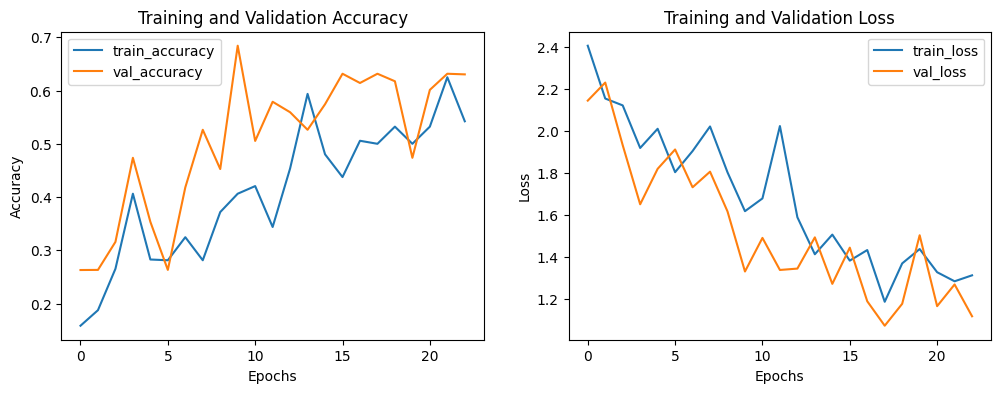

In [7]:
# plot training results for visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

Discussions: As epoch increments, we can see train loss and validation loss decrementing which show the models is being improved. The train loss and accuracy are reaching their peaks which means they cant be improved much futher. Validation loss and accuracy are stable but they are up and down which is normal. For example: accuracy: 0.1181 - loss: 2.4584 - val_accuracy: 0.2629 - val_loss: 2.1443. At the end, the values are accuracy: 0.6250 - loss: 1.2830 - val_accuracy: 0.6316 - val_loss: 1.2679

### 7. Apply CNN on the test data


#### A. Use the latest model for test data

In [8]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col=None,
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False
)
print(f"test_dir {test_dir}")
print(f"test_generator.samples {test_generator.samples}")

predictions = best_model.predict(test_generator, steps=test_generator.samples)
predicted_class_indices = np.argmax(predictions, axis=1)

# Map the predicted indices to class labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]



Found 794 validated image filenames.
test_dir /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week6/input/test/
test_generator.samples 794
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


#### B. Display plots

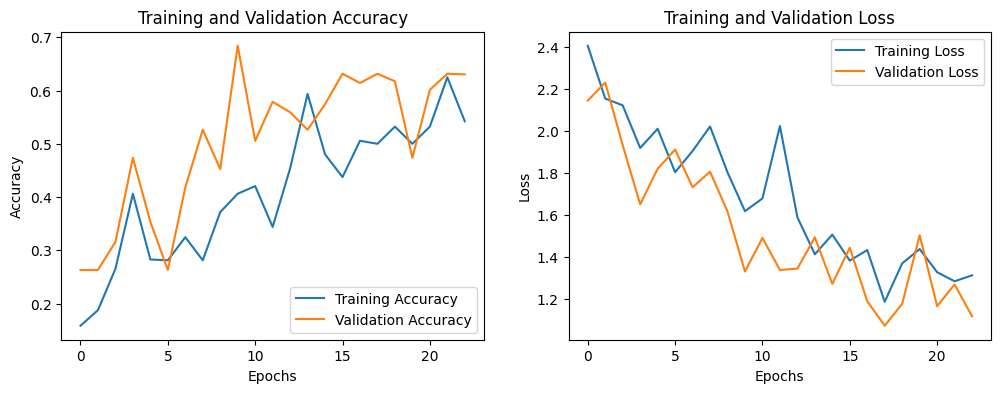

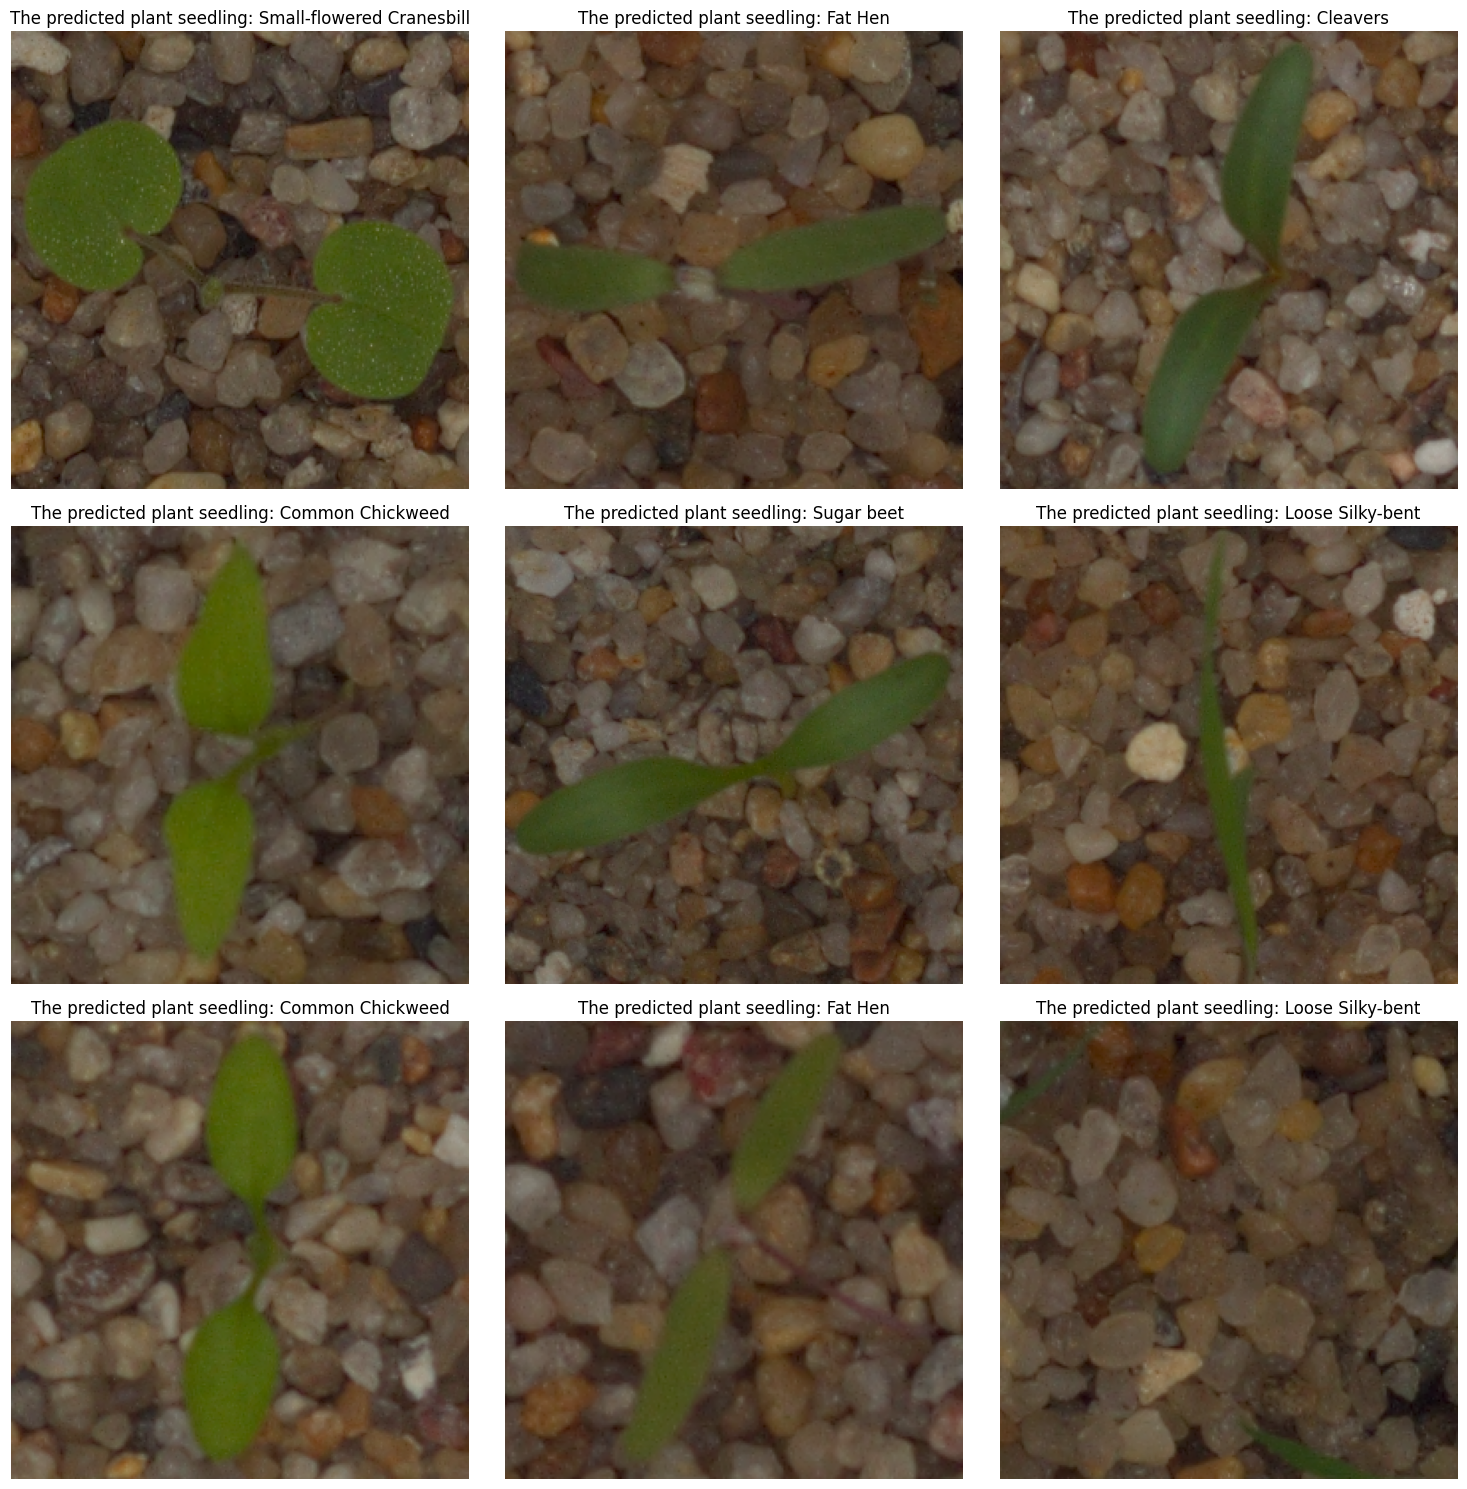

In [12]:
# Visualize the training process
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# show some results
num_images_to_display = 9

# Get filenames and predicted labels
filenames = test_generator.filenames[:num_images_to_display]
predicted_labels = [labels[k] for k in np.argmax(predictions[:num_images_to_display], axis=1)]

# Plot the images with their predicted labels
plt.figure(figsize=(15, 15))
for i in range(num_images_to_display):
    img_path = os.path.join(test_dir, filenames[i])
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'The predicted plant seedling: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Discussions: From trainng with test data used the same model that yields the best results. The results show the types of each seed.

### 8. Takeways

In conclusion, the last model yields the best results because it has more epoch and more dense in each layer; therefore, the data goes through a lot iterations which improves accuracy and reduces loss. 

Validation Loss: 1.2830
Validation Accuracy: 0.6250

The results seem to be okay. 

There were some issues, and I resolved them. I ran out of training data, so I had to adjust steps per epoch and validation steps. I was getting out of range sequence, so I added shuffle to flow to dictionary.

The loss and result diagrams show the significant trendlines at the begining and they also dont change much at the end. This means the current model had peaked and couldnt be improve much more.

What I could improve was incrementing buffer size so some of the training didn't need to shuffle which may alter the results.
The speed of training can be improved if the better computer with GPU that supported model training.
I believe if I get more input data to train, results could be improved further.

